In [ ]:
os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial /kaggle/working/test-data')

In [ ]:
!pip3 install -U kaleido

In [1]:
import os
import numpy as np
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
import cv2
import json
from PIL import Image
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

In [2]:
base_path = './'

In [3]:
wsi_df = pd.read_csv(f'{base_path}/wsi_meta.csv')
wsi_df.head()

,source_wsi,age,sex,race,height,weight,bmi
0,1,58,F,W,160.0,59.0,23.0
1,2,56,F,W,175.2,139.6,45.5
2,3,73,F,W,162.3,87.5,33.2
3,4,53,M,B,166.0,73.0,26.5


In [4]:
tile_df = pd.read_csv(f'{base_path}/tile_meta.csv')
tile_df.head()

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
1,000e79e206b7,6,3,10240,29184
2,00168d1b7522,2,2,14848,14884
3,00176a88fdb0,7,3,14848,25088
4,0033bbc76b6b,1,1,10240,43008


In [5]:
tile_df.describe()

,source_wsi,dataset,i,j
count,7033.000000,7033.000000,7033.000000,7033.000000
mean,8.205744,2.707806,14296.542585,23227.014930
std,4.004251,0.571724,5946.054578,10644.032931
min,1.000000,1.000000,1536.000000,2560.000000
25%,6.000000,3.000000,9728.000000,15265.000000
50%,9.000000,3.000000,13824.000000,22528.000000
75%,12.000000,3.000000,18944.000000,29656.000000
max,14.000000,3.000000,30208.000000,52753.000000


In [6]:
def find_img_dists(tile_df):
  fig, axes = plt.subplots(1, 4, figsize=(15, 5))
  fig.tight_layout(pad=5.0)
  wsi_by_count = tile_df.groupby('source_wsi').agg({'id': pd.Series.nunique}).rename(columns={'id': 'img_cnt'})[['img_cnt']].reset_index(drop=False)
  dataset_by_count = tile_df.groupby('dataset').agg({'id': pd.Series.nunique}).rename(columns={'id': 'img_cnt'})[['img_cnt']].reset_index(drop=False)
  dataset_by_wsi = tile_df.groupby('dataset').agg({'source_wsi': pd.Series.nunique}).rename(columns={'source_wsi': 'source_wsi_cnt'})[['source_wsi_cnt']].reset_index(drop=False)
  wsi_by_dataset = tile_df.groupby('source_wsi').agg({'dataset': pd.Series.nunique}).rename(columns={'dataset': 'dataset_cnt'})[['dataset_cnt']].reset_index(drop=False)
  # dataset_by_wsi.head()
  sns.barplot(ax=axes[0], data=wsi_by_count, x="source_wsi", y="img_cnt")
  axes[0].set_title('Source WSI By Image Count')
  sns.barplot(ax=axes[1], data=dataset_by_count, x="dataset", y="img_cnt")
  axes[1].set_title('Dataset By Image Count')
  sns.barplot(ax=axes[2], data=dataset_by_wsi, x="dataset", y="source_wsi_cnt")
  axes[2].set_title('Dataset By Source WSI Count')
  sns.barplot(ax=axes[3], data=wsi_by_dataset, x="source_wsi", y="dataset_cnt")
  axes[3].set_title('Source WSI By Dataset Count')

In [7]:
with open(f'{base_path}/polygons.jsonl', 'r') as json_file:
    json_list = list(json_file)
    
tiles_dicts = []
for json_str in json_list:
    tiles_dicts.append(json.loads(json_str))

In [8]:
def get_count_type(tiles_dict):
  ids_with_info = []
  for tile in tiles_dict:
    cur_dict = {'id': tile['id'], 'blood_vessel': 0, 'glomerulus': 0, 'unsure': 0}
    for annot in tile['annotations']:
      cur_dict[annot['type']] += 1
    ids_with_info.append(cur_dict)
  return ids_with_info

In [9]:
tiles_dicts[0]

{'id': '0006ff2aa7cd',
 'annotations': [{'type': 'glomerulus',
   'coordinates': [[[167, 249],
     [166, 249],
     [165, 249],
     [164, 249],
     [163, 249],
     [162, 249],
     [161, 249],
     [160, 249],
     [159, 249],
     [158, 249],
     [157, 249],
     [156, 249],
     [155, 249],
     [154, 249],
     [153, 249],
     [152, 249],
     [151, 249],
     [150, 249],
     [149, 249],
     [148, 249],
     [147, 249],
     [146, 249],
     [145, 249],
     [144, 249],
     [143, 249],
     [142, 249],
     [141, 249],
     [140, 249],
     [139, 249],
     [138, 249],
     [137, 249],
     [136, 249],
     [135, 249],
     [134, 249],
     [133, 249],
     [132, 249],
     [131, 249],
     [130, 249],
     [129, 249],
     [128, 249],
     [127, 249],
     [126, 249],
     [125, 249],
     [124, 249],
     [123, 249],
     [122, 249],
     [122, 248],
     [121, 248],
     [120, 248],
     [119, 248],
     [118, 248],
     [117, 248],
     [117, 247],
     [116, 247],
    

In [10]:
# Find the same stats as the above cell for annotated images
annotated_ids_with_info = get_count_type(tiles_dicts)
annotated_ids_with_info_df = pd.DataFrame.from_dict(annotated_ids_with_info)
tile_df_annotated = pd.merge(tile_df, annotated_ids_with_info_df, on='id', how='inner')
tile_df_annotated.head()

,id,source_wsi,dataset,i,j,blood_vessel,glomerulus,unsure
0,0006ff2aa7cd,2,2,16896,16420,8,1,0
1,00168d1b7522,2,2,14848,14884,1,1,0
2,0033bbc76b6b,1,1,10240,43008,3,0,1
3,003504460b3a,3,2,8192,11776,7,0,0
4,004daf1cbe75,3,2,6144,11264,10,1,0


In [11]:
tile_df_annotated.describe()

,source_wsi,dataset,i,j,blood_vessel,glomerulus,unsure
count,1633.000000,1633.00000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000
mean,2.272505,1.74158,11514.199633,19736.355175,9.830986,0.347214,0.549296
std,1.073219,0.43790,6565.735338,12142.219076,6.359307,0.663348,1.371158
min,1.000000,1.00000,1536.000000,2560.000000,0.000000,0.000000,0.000000
25%,1.000000,1.00000,6656.000000,10240.000000,5.000000,0.000000,0.000000
50%,2.000000,2.00000,10240.000000,17956.000000,9.000000,0.000000,0.000000
75%,3.000000,2.00000,16384.000000,24064.000000,13.000000,1.000000,0.000000
max,4.000000,2.00000,30208.000000,46592.000000,51.000000,6.000000,18.000000


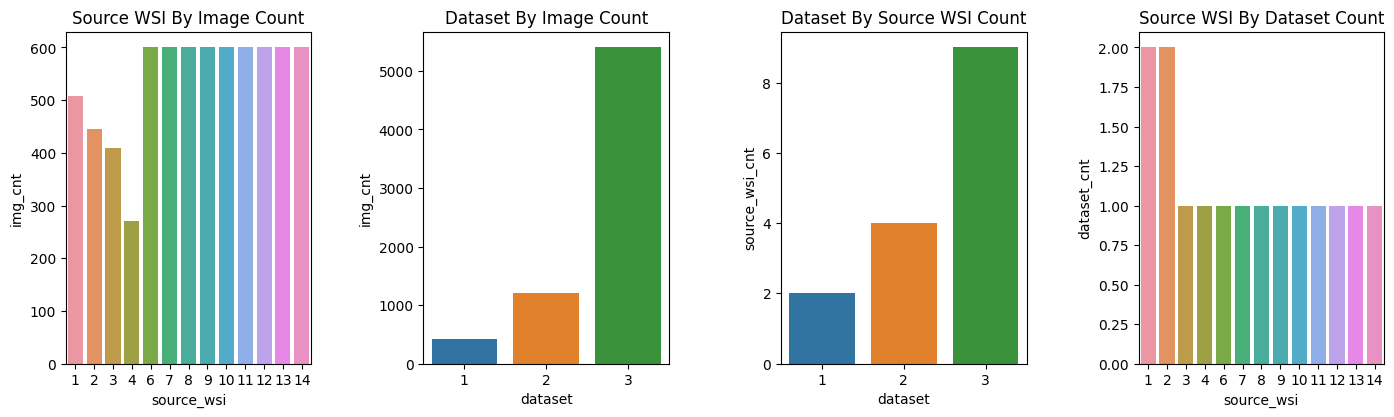

In [12]:
find_img_dists(tile_df)

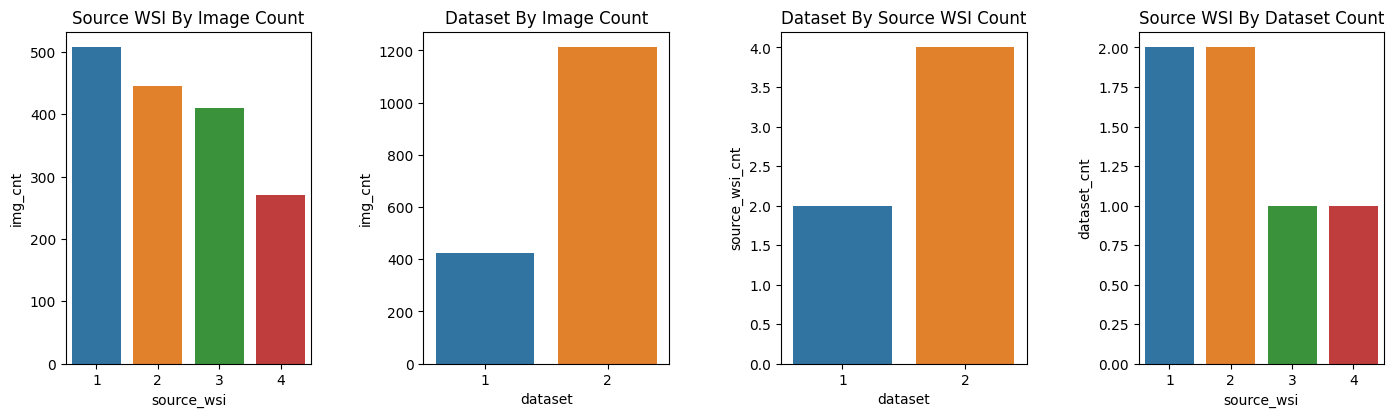

In [13]:
find_img_dists(tile_df_annotated)

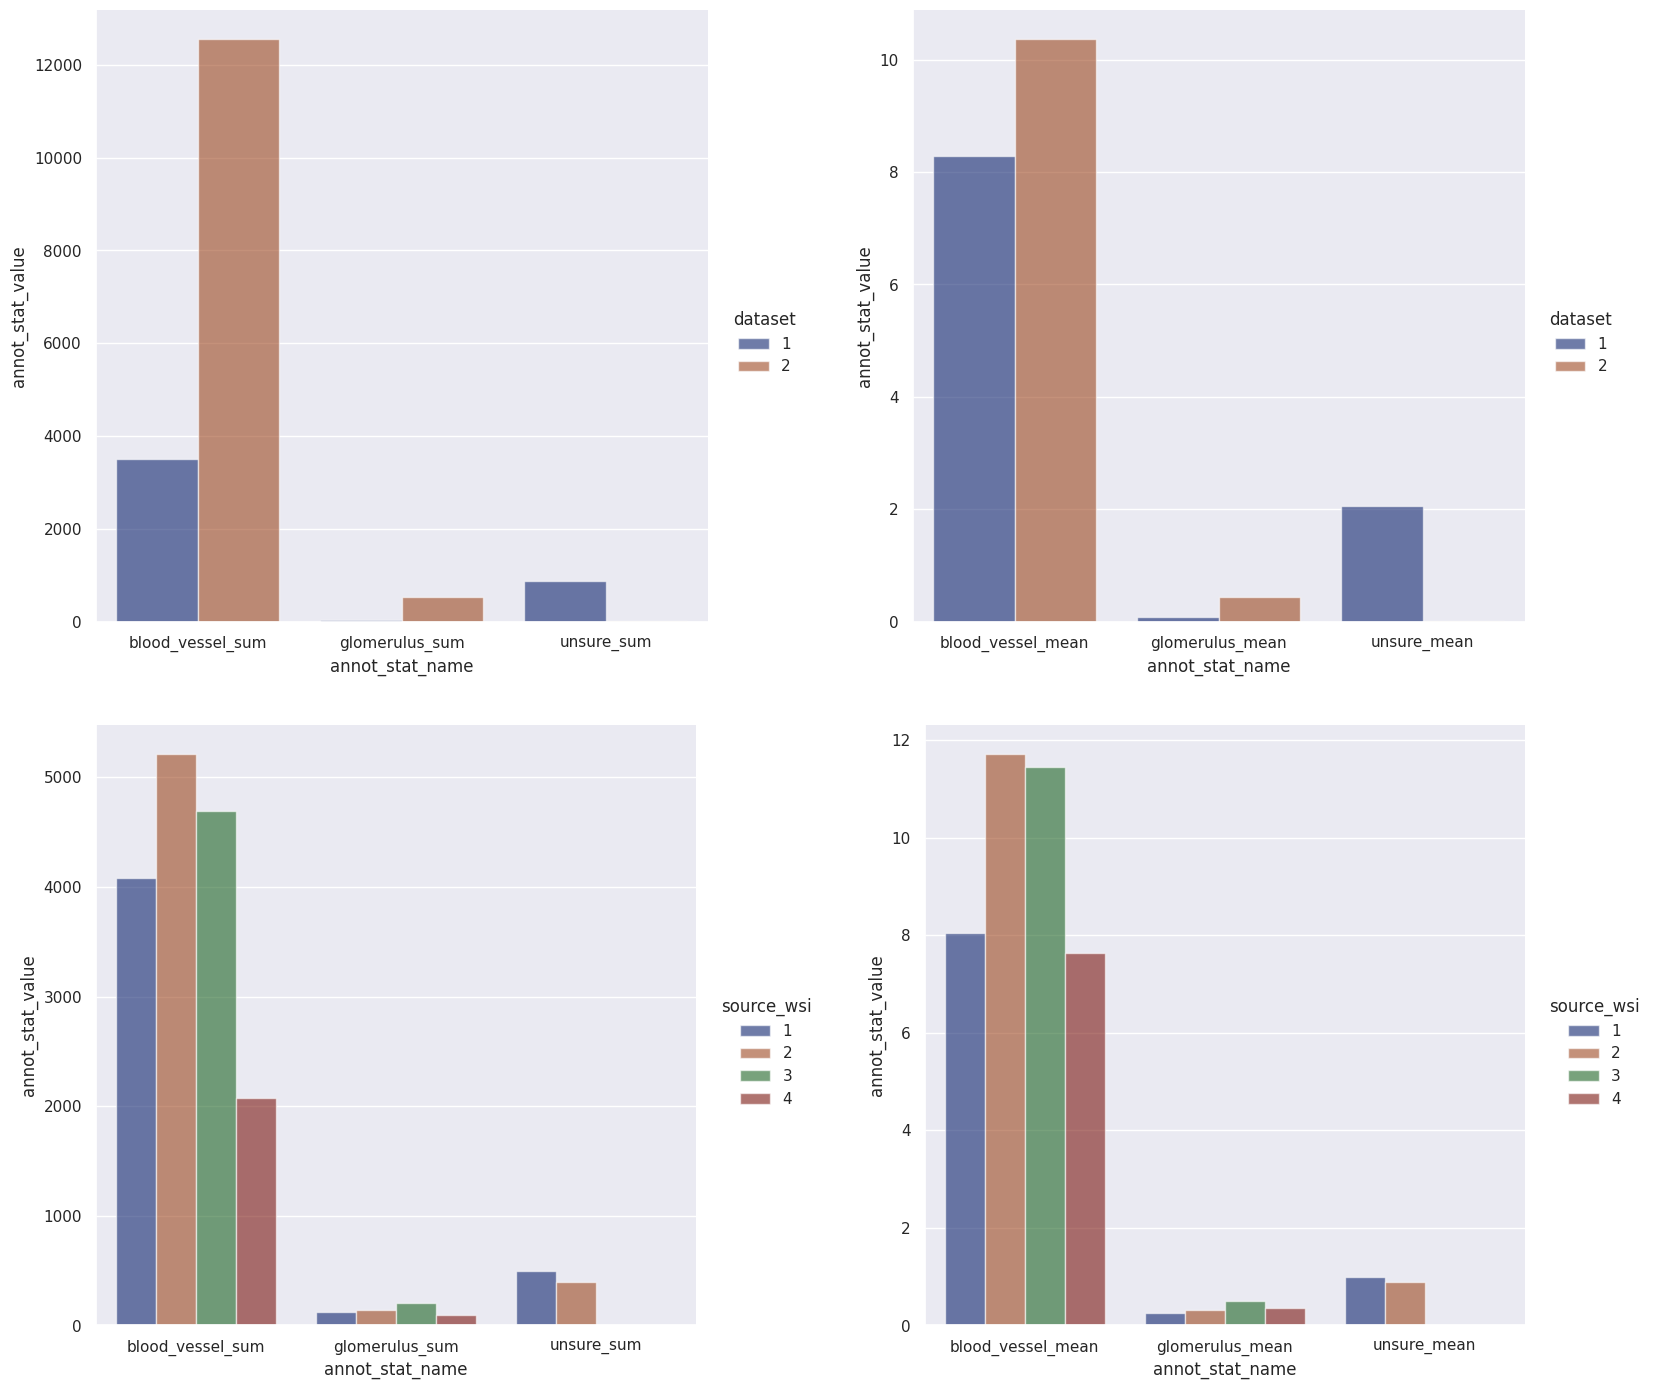

In [21]:
import patchworklib as pw
pw.overwrite_axisgrid()
sns.set()
wsi_by_annot_counts = tile_df_annotated.groupby('source_wsi').agg({'blood_vessel': ['sum', 'mean'],'glomerulus': ['sum', 'mean'],'unsure': ['sum', 'mean']})
wsi_by_annot_counts.columns = ['_'.join(x) for x in wsi_by_annot_counts.columns]
wsi_by_annot_counts = wsi_by_annot_counts.reset_index(drop=False)
melt_value_vars = [x for x in wsi_by_annot_counts.columns if x!='source_wsi']
wsi_by_annot_counts = wsi_by_annot_counts.melt(id_vars=['source_wsi'], value_vars=melt_value_vars).rename(columns={'variable': 'annot_stat_name', 'value': 'annot_stat_value'})
dataset_by_annot_counts = tile_df_annotated.groupby('dataset').agg({'blood_vessel': ['sum', 'mean'],'glomerulus': ['sum', 'mean'],'unsure': ['sum', 'mean']})
dataset_by_annot_counts.columns = ['_'.join(x) for x in dataset_by_annot_counts.columns]
dataset_by_annot_counts = dataset_by_annot_counts.reset_index(drop=False)
melt_value_vars = [x for x in dataset_by_annot_counts.columns if x!='dataset']
dataset_by_annot_counts = dataset_by_annot_counts.melt(id_vars=['dataset'], value_vars=melt_value_vars).rename(columns={'variable': 'annot_stat_name', 'value': 'annot_stat_value'})
g1 = sns.catplot(
    data=dataset_by_annot_counts.loc[dataset_by_annot_counts['annot_stat_name'].str.contains('sum')], kind="bar",
    x="annot_stat_name", y="annot_stat_value", hue="dataset",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g1 = pw.load_seaborngrid(g1)
g2 = sns.catplot(
    data=dataset_by_annot_counts.loc[dataset_by_annot_counts['annot_stat_name'].str.contains('mean')], kind="bar",
    x="annot_stat_name", y="annot_stat_value", hue="dataset",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g2 = pw.load_seaborngrid(g2)
g3 = sns.catplot(
    data=wsi_by_annot_counts.loc[wsi_by_annot_counts['annot_stat_name'].str.contains('sum')], kind="bar",
    x="annot_stat_name", y="annot_stat_value", hue="source_wsi",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g3 = pw.load_seaborngrid(g3)
g4 = sns.catplot(
    data=wsi_by_annot_counts.loc[wsi_by_annot_counts['annot_stat_name'].str.contains('mean')], kind="bar",
    x="annot_stat_name", y="annot_stat_value", hue="source_wsi",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g4 = pw.load_seaborngrid(g4)
((g1|g2)/(g3|g4)).savefig()
# plt.xticks(rotation=45)
# fig.tight_layout(pad=5.0)
# plt.close()

In [16]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [17]:
class CFG:
    img_path_template: str = "./train/{}.tif"

In [18]:
def get_cartesian_coords(coords, img_height):
    coords_array = np.array(coords).squeeze()
    xs = coords_array[:, 0]
    ys = -coords_array[:, 1] + img_height
    
    return xs, ys

In [19]:
def plot_annotated_image(image_dict, scale_factor: int = 1.0) -> None:
    array = tiff.imread(CFG.img_path_template.format(image_dict["id"]))
    img_example = Image.fromarray(array)
    annotations = image_dict["annotations"]
    
    # create figure
    fig = go.Figure()

    # constants
    img_width = img_example.size[0]
    img_height = img_example.size[1]
    

    # add invisible scatter trace
    fig.add_trace(
        go.Scatter(
            x=[0, img_width],
            y=[0, img_height],
            mode="markers",
            marker_opacity=0
        )
    )

    # configure axes
    fig.update_xaxes(
        visible=False,
        range=[0, img_width]
    )

    fig.update_yaxes(
        visible=False,
        range=[0, img_height],
        # the scaleanchor attribute ensures that the aspect ratio stays constant
        scaleanchor="x"
    )

    # add image
    fig.add_layout_image(dict(
        x=0,
        sizex=img_width,
        y=img_height,
        sizey=img_height,
        xref="x", yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=img_example
    ))
    
    # add polygons
    for annotation in annotations:
        name = annotation["type"]
        xs, ys = get_cartesian_coords(annotation["coordinates"], img_height)
        fig.add_trace(go.Scatter(
            x=xs, y=ys, fill="toself",
            name=name,
            hovertemplate="%{name}",
            mode='lines'
        ))

    # configure other layout
    fig.update_layout(
        width=img_width * scale_factor,
        height=img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
        showlegend=False
    )

    # disable the autosize on double click because it adds unwanted margins around the image
    # and finally show figure
    fig.show(config={'doubleClick': 'reset'})
#     plt.imshow(fig)
#     return fig 
#     fig.write_image('/kaggle/working/img.jpg')
#     annotated_img = Image.open('/kaggle/working/img.jpg')
#     return annotated_img

In [20]:
tiles_dicts[0]

{'id': '0006ff2aa7cd',
 'annotations': [{'type': 'glomerulus',
   'coordinates': [[[167, 249],
     [166, 249],
     [165, 249],
     [164, 249],
     [163, 249],
     [162, 249],
     [161, 249],
     [160, 249],
     [159, 249],
     [158, 249],
     [157, 249],
     [156, 249],
     [155, 249],
     [154, 249],
     [153, 249],
     [152, 249],
     [151, 249],
     [150, 249],
     [149, 249],
     [148, 249],
     [147, 249],
     [146, 249],
     [145, 249],
     [144, 249],
     [143, 249],
     [142, 249],
     [141, 249],
     [140, 249],
     [139, 249],
     [138, 249],
     [137, 249],
     [136, 249],
     [135, 249],
     [134, 249],
     [133, 249],
     [132, 249],
     [131, 249],
     [130, 249],
     [129, 249],
     [128, 249],
     [127, 249],
     [126, 249],
     [125, 249],
     [124, 249],
     [123, 249],
     [122, 249],
     [122, 248],
     [121, 248],
     [120, 248],
     [119, 248],
     [118, 248],
     [117, 248],
     [117, 247],
     [116, 247],
    

(512, 512)



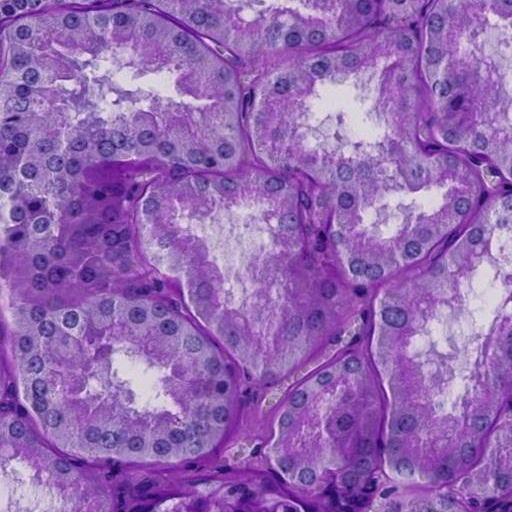

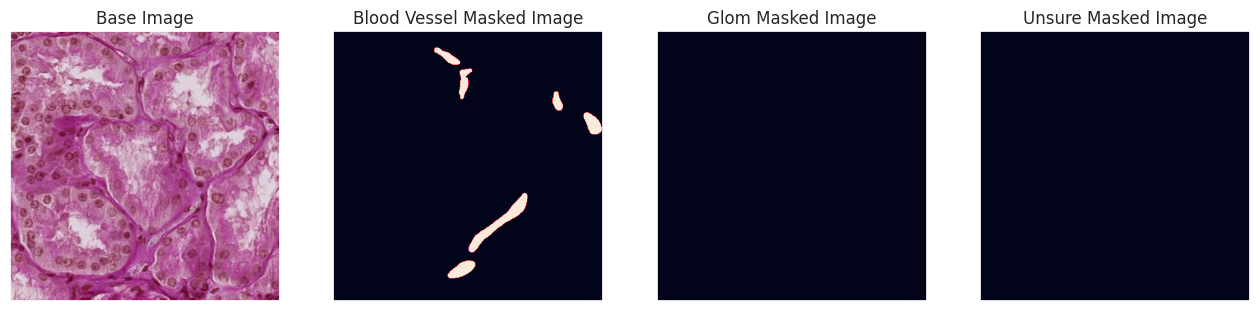

In [35]:
from PIL import Image
tile_idx = 40
img_id = tiles_dicts[tile_idx]['id']
base_image = cv2.imread(f'{base_path}/train/{img_id}.tif')
blood_vessel_masked_image = np.zeros((512, 512))
glom_masked_image = np.zeros((512, 512))
unsure_masked_image = np.zeros((512, 512))
for annot_idx in range(0, len(tiles_dicts[tile_idx]['annotations'])):
    coords = np.array(tiles_dicts[tile_idx]['annotations'][annot_idx]['coordinates'][0])
    mask_type = tiles_dicts[tile_idx]['annotations'][annot_idx]['type']
    if mask_type == 'blood_vessel':
        cv2.fillPoly(blood_vessel_masked_image, pts=[coords], color=1)
#     elif mask_type == 'glomerulus':
#         cv2.fillPoly(glom_masked_image, pts=[coords], color=(0, 0, 255))
#     else:
#         cv2.fillPoly(unsure_masked_image, pts=[coords], color=(255, 0, 0))
# print(base_image.shape, masked_image.shape)
# print(mask_type)
print(blood_vessel_masked_image.shape)
blood_vessel_masked_image = Image.fromarray(blood_vessel_masked_image.astype(np.uint8))
glom_masked_image = Image.fromarray(glom_masked_image.astype(np.uint8)).convert('L')
unsure_masked_image = Image.fromarray(unsure_masked_image.astype(np.uint8)).convert('L')
plot_annotated_image(tiles_dicts[tile_idx])
visualize(base_image=base_image, blood_vessel_masked_image=blood_vessel_masked_image, glom_masked_image=glom_masked_image, unsure_masked_image=unsure_masked_image)

In [59]:
def save_imgs_and_masks(img_tiles_dicts, output_dir, output_mask_dir):
  for img_tiles_dict in img_tiles_dicts:
    img_id = img_tiles_dict['id']
    base_image = cv2.imread(f'{base_path}/train/{img_id}.tif')
    blood_vessel_masked_image = np.zeros((512, 512))
    for annot_idx in range(0, len(img_tiles_dict['annotations'])):
        coords = np.array(img_tiles_dict['annotations'][annot_idx]['coordinates'][0])
        mask_type = img_tiles_dict['annotations'][annot_idx]['type']
        if mask_type == 'blood_vessel':
            cv2.fillPoly(blood_vessel_masked_image, pts=[coords], color=1)
    blood_vessel_masked_image = Image.fromarray(blood_vessel_masked_image.astype(np.uint8))
    base_image = Image.fromarray(base_image.astype(np.uint8))
    base_image.save(f'{output_dir}/{img_id}.png')
    blood_vessel_masked_image.save(f'{output_mask_dir}/{img_id}.png')

In [60]:
np.random.seed(42)
np.random.shuffle(tiles_dicts)
train_pct = 0.8
all_train_dicts = tiles_dicts[:int(train_pct*len(tiles_dicts))]
all_valid_dicts = tiles_dicts[int(train_pct*len(tiles_dicts)):]
len(all_train_dicts), len(all_valid_dicts)

(1306, 327)

In [61]:
from PIL import Image
import shutil
if os.path.exists('./all_train_imgs'):
  shutil.rmtree('./all_train_imgs')
if os.path.exists('./all_valid_imgs'):
  shutil.rmtree('./all_valid_imgs')
if os.path.exists('./all_train_masks'):
  shutil.rmtree('./all_train_masks')
if os.path.exists('./all_valid_masks'):
  shutil.rmtree('./all_valid_masks') 

os.mkdir('./all_train_imgs')
os.mkdir('./all_valid_imgs')
os.mkdir('./all_train_masks')
os.mkdir('./all_valid_masks')
print(f'Processing a total of {len(all_train_dicts)} training images and {len(all_valid_dicts)} validation images')
save_imgs_and_masks(all_train_dicts, './all_train_imgs', './all_train_masks')
save_imgs_and_masks(all_valid_dicts, './all_valid_imgs', './all_valid_masks')

Processing a total of 1306 training images and 327 validation images


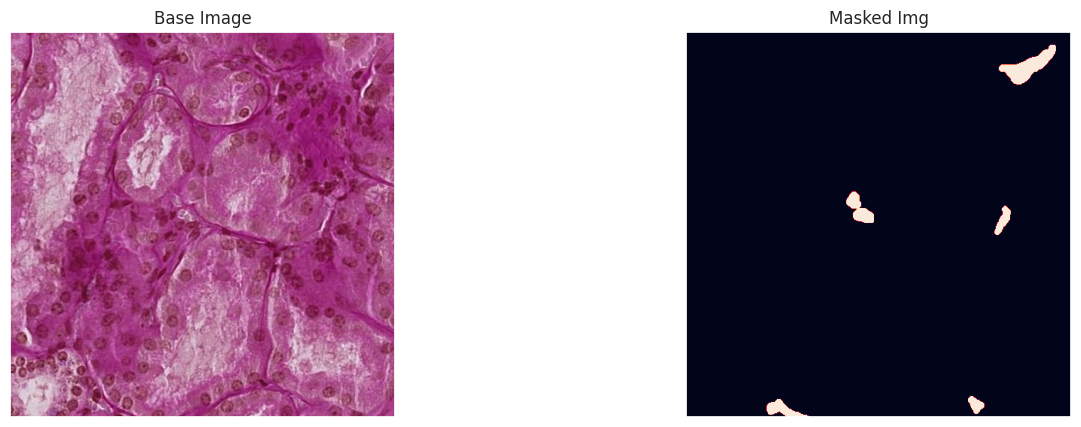

In [69]:
tiles_idx = 50
cur_id = all_valid_dicts[tiles_idx]['id']
base_image = Image.open(f'./all_valid_imgs/{cur_id}.png')
masked_img = Image.open(f'./all_valid_masks/{cur_id}.png')
visualize(base_image=base_image, masked_img=masked_img)